# **Exploration of Exoplanets and Solar System Planets!**

*Author: Anton Zaitsev*  
*Date: December 21, 2023*

---------

# Data

## NASA Exoplanet Archive

https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=PS

## Solar System Major Bodies Data

https://www.kaggle.com/datasets/jaredsavage/solar-system-major-bodies-data

## Kepler Confirmed Planets

https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=kep_conf_names


## Equilibrium Temperatures for Solar Planets

http://astro.vaporia.com/start/equilibriumtemperature.html

## The Distances from the Solar Planets to the Earth

https://promenade.imcce.fr/en/pages5/573.html

## Data Description

### NASA Exoplanet Archive

NASA Exoplanet Archive dataset contains information on confirmed planets outside of the Solar System, e.g. planet mass, radius, planet discovery method, orbital period, etc.

Rows: 35131
Columns: 286

### Solar System Major Bodies Data

The Solar System Planets dataset contains information on major bodies inside the Solar System, including planets, such as Earth, Mars, Venus, etc. It includes information on body's attributes, such as mass, density, etc.

Rows: 31
Columns: 265

### Kepler Confirmed Planets

The Kepler Confirmed Planets dataset includes information about exoplanets that have been confirmed through observations by NASA's Kepler mission. Kepler-confirmed planets are those KOIs that have undergone further scrutiny and have been confirmed as actual exoplanets through additional observations. The confirmation process aims to rule out false positives and confirm that the observed signals are consistent with the presence of planets.

Rows: 2807
Columns: 4

---------



In [136]:
# Imports

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from matplotlib.colors import Normalize
from IPython.display import Image
import matplotlib.patheffects as pe
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap

In [57]:
# Global Variables
EXOPLANETS_PATH = 'data/exoplanets.csv'
EXOPLANETS_HEADER = 290
SOLARPLANETS_URL = 'data/solarplanets.csv'
KEPLER_PATH = 'data/kepler.csv'
KEPLER_HEADER = 8
PLOTS_SAVE_DIR = 'plots/'


In [58]:
## Exoplanets
descriptions = pd.read_csv(EXOPLANETS_PATH, nrows=EXOPLANETS_HEADER - 1)[2:-1].iloc[:, 0].tolist()
column_descriptions = {}
for item in descriptions:
    parts = item.split(':')
    if len(parts) == 2:
        key = parts[0].strip().split()[-1]
        value = parts[1].strip()
        column_descriptions[key] = value

columns_considered = [
    'pl_name', 'hostname', 'disc_year', 'discoverymethod', 
    'pl_controv_flag', 'sy_snum', 'sy_pnum', 'sy_mnum',
    'pl_orbper', 'pl_rade', 'pl_masse', 'pl_dens',
    'pl_orbeccen', 'pl_insol', 'pl_eqt', 'pl_orbincl',
    'st_teff', 'st_rad', 'st_mass', 'st_lum', 
    'st_logg', 'st_age', 'st_dens', 'sy_dist', 'pl_orbsmax',
    'ra', 'dec'
]
exoplanets_dirty = pd.read_csv(EXOPLANETS_PATH, header=EXOPLANETS_HEADER, usecols=columns_considered, index_col=None)

columns_group = ['pl_name', 'hostname', 'disc_year', 'discoverymethod']
exoplanets = exoplanets_dirty.groupby(columns_group).mean()
exoplanets = exoplanets.reset_index()

exoplanets['sy_dist_log'] = np.log10(exoplanets['sy_dist'])


In [59]:
## Solar Planets
solar_bodies = pd.read_csv(SOLARPLANETS_URL)
solarplanets_names = ['Mercury', 'Venus', 'Earth', 'Mars', 'Jupiter', 'Saturn', 'Uranus', 'Neptune']
solarplanets = solar_bodies[solar_bodies['eName'].isin(solarplanets_names)].reset_index()
solarplanets['pl_eqt'] = [64, 51, 122, 226, 449, 90, 279, 328]
au_parcec = 206265
solarplanets['earth_dist_avg'] = [
    (17.292 + 21.089)/au_parcec,
    (28.817 + 31.317)/au_parcec,
    (3.957 + 6.454)/au_parcec,
    (0.372 + 2.671)/au_parcec,
    (0.552 + 1.446)/au_parcec,
    (8.050 + 11.046)/au_parcec,
    0/au_parcec,
    (0.266 + 1.736)/au_parcec
]
solarplanets['st_mass'] = 1
solarplanets['hab_zone_inner_lum'] = 0.95
solarplanets['hab_zone_outer_lum'] = 1.37

# convert features to earth scale
earth_mass = solarplanets.loc[solarplanets['eName'] == 'Earth', 'mass_kg'].values[0]
earth_radius = solarplanets.loc[solarplanets['eName'] == 'Earth', 'meanRadius'].values[0]
solarplanets['mass_earth'] = solarplanets['mass_kg'] / earth_mass
solarplanets['radius_earth'] = solarplanets['meanRadius'] / earth_radius

# rename column to match with exoplanets
solarplanets_rename_cols = {'mass_earth': 'pl_masse', 'sideralOrbit': 'pl_orbper', 'semimajorAxis_AU': 'pl_orbsmax', 'radius_earth': 'pl_rade', 'pl_eqt': 'pl_eqt', 'eName': 'pl_name', 'earth_dist_avg': 'sy_dist'}
solarplanets.rename(columns=solarplanets_rename_cols, inplace=True)

# define earth and solarplanets data separately
earth = solarplanets[solarplanets['pl_name'] == 'Earth']

In [60]:
## Kepler Planets
keplerplanets = pd.read_csv(KEPLER_PATH, header=KEPLER_HEADER, index_col=None)

In [61]:
### Join Exoplanets and Kepler Confirmed Planets
exoplanets = exoplanets.copy() 
exoplanets['kepler_confirmed'] = exoplanets['pl_name'].isin(keplerplanets['pl_name'])
exoplanets['kepler_confirmed'] = exoplanets['kepler_confirmed'].astype(bool)

In [62]:
# Data for Animation
animation_cols= ['pl_orbper', 'pl_orbsmax', 'pl_rade', 'pl_eqt', 'pl_name', 'sy_dist']
exoplanets_animation = exoplanets[animation_cols]
solarplanets_animation = solarplanets[animation_cols]
earth_animation = earth[animation_cols]
solar_exo_animation = pd.concat([exoplanets_animation, solarplanets_animation, earth_animation], ignore_index=True)
solar_exo_animation = solar_exo_animation.dropna(subset=['pl_orbper', 'pl_orbsmax', 'pl_rade', 'pl_eqt', 'sy_dist'])

# Exploratory Analysis

> - An astronomical unit (AU) is a unit of measurement equal to the average distance between a planet and its host star.
>   - 1 AU is the average distance from the Earth to the Sun.
>   - 1 AU = 1.5 x 10^8 KM (150 million kilometers)
>   - 1 Parsec = 206,265 AU
>   - 1 Parsec = 3.09 x 10^13 KM

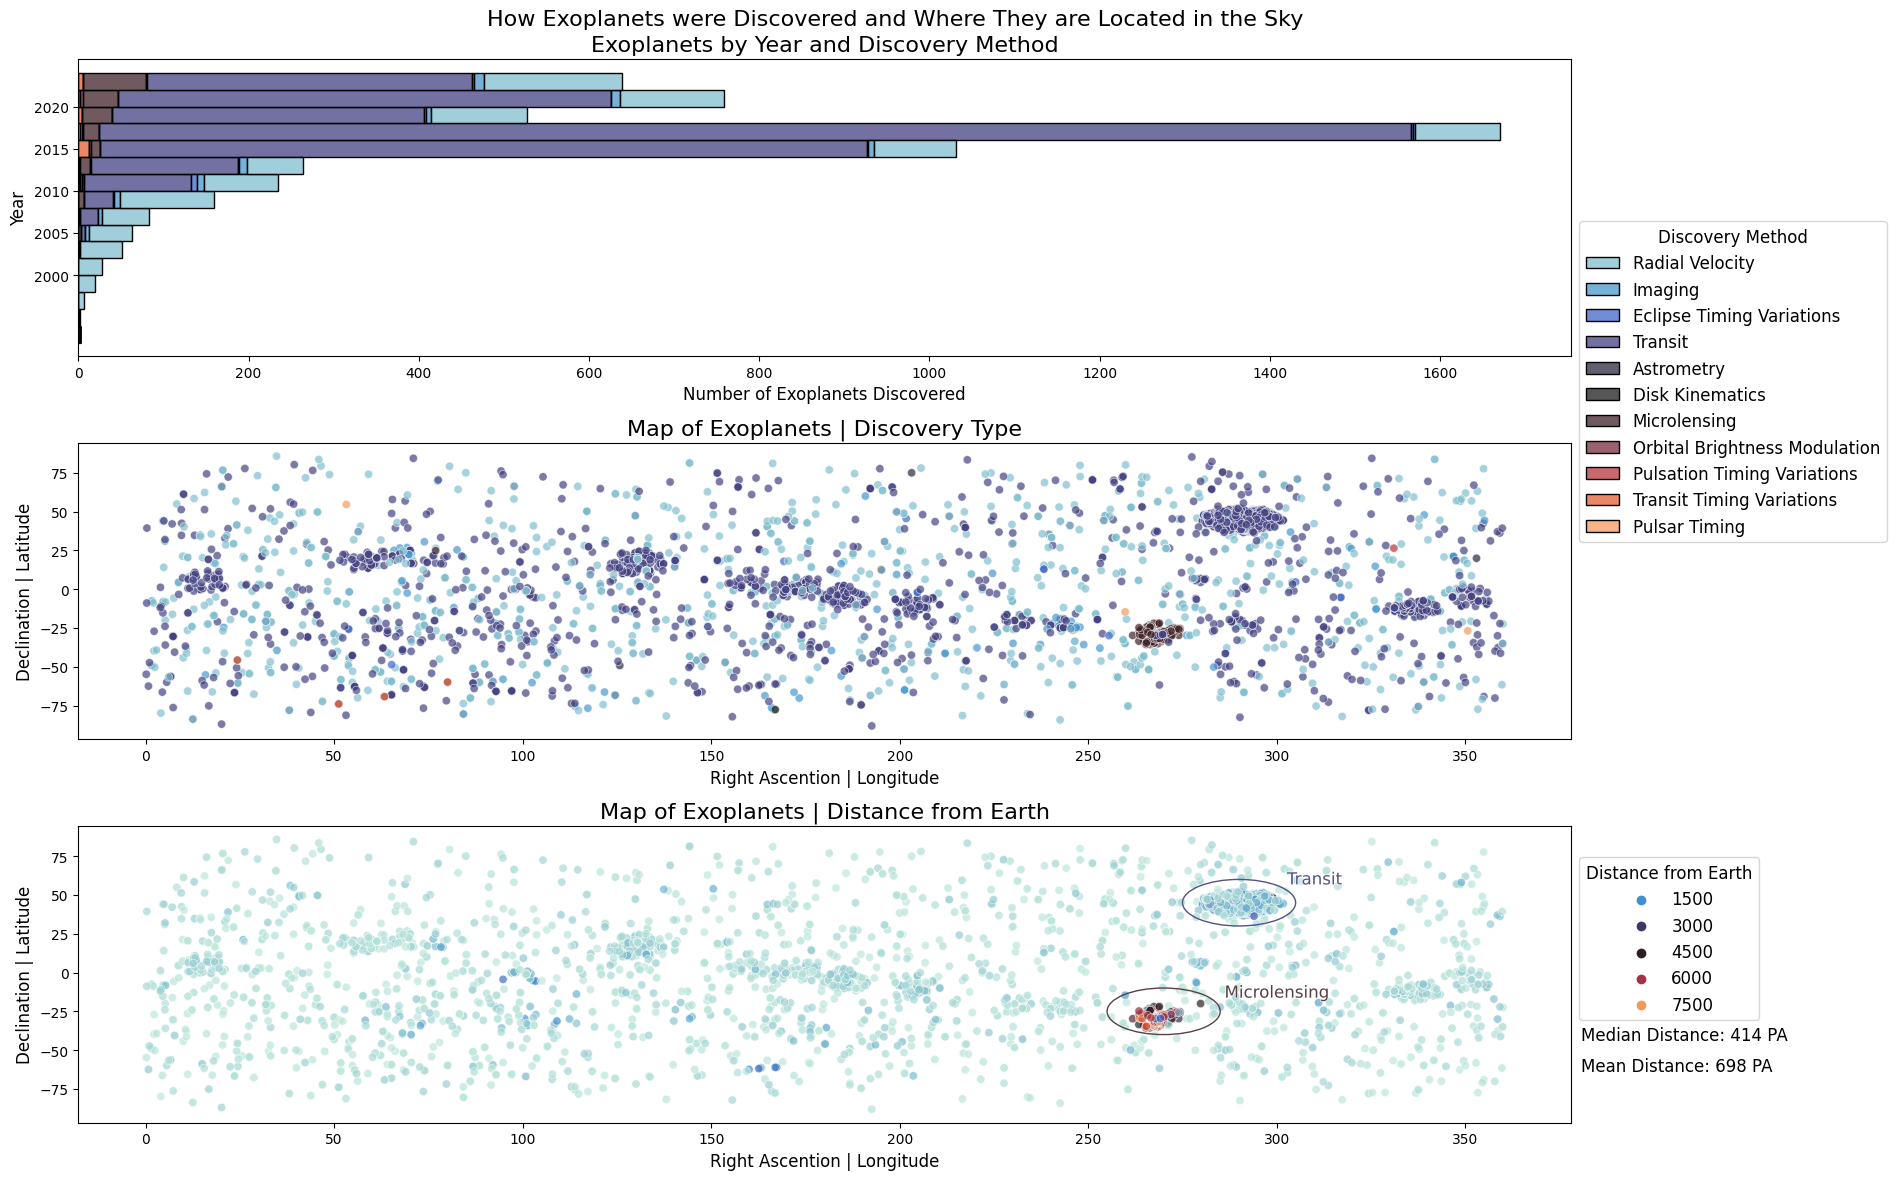

In [63]:
## Discovery Method & Location in Sky
fig = plt.figure(figsize=(18, 12))
gridspan = fig.add_gridspec(3, 1)
fig.suptitle("How Exoplanets were Discovered and Where They are Located in the Sky", fontsize=16)
 
ax1 = fig.add_subplot(gridspan[0, :])
ax2 = fig.add_subplot(gridspan[1, :])
ax3 = fig.add_subplot(gridspan[2, :])

ax1_legend = sns.histplot(
    data=exoplanets, 
    y='disc_year', 
    multiple="stack",
    binwidth=2, 
    hue='discoverymethod', 
    palette='icefire',
    ax=ax1
).get_legend()
ax1.set_title('Exoplanets by Year and Discovery Method', fontsize=16)
ax1.set_xlabel('Number of Exoplanets Discovered',fontsize=12)
ax1.set_ylabel('Year',fontsize=12)
ax1.set_yticks(range(2000, max(exoplanets['disc_year'])+1, 5))

sns.scatterplot(
    x='ra', 
    y='dec', 
    hue='discoverymethod', 
    palette='icefire',
    data=exoplanets, 
    alpha=0.7, 
    ax=ax2
)
ax2.set_title("Map of Exoplanets | Discovery Type", fontsize=16)
ax2.set_xlabel("Right Ascention | Longitude", fontsize=12)
ax2.set_ylabel("Declination | Latitude", fontsize=12)

ax3_legend = sns.scatterplot(
    x='ra', 
    y='dec', 
    hue='sy_dist', 
    palette='icefire',
    data=exoplanets, 
    alpha=0.7, 
    ax=ax3
).get_legend()
ax3.set_title("Map of Exoplanets | Distance from Earth", fontsize=16)
ax3.set_xlabel("Right Ascention | Longitude", fontsize=12)
ax3.set_ylabel("Declination | Latitude", fontsize=12)

transit_circle_center = (290, 45)
transit_circle_radius = 15
transit_circle = plt.Circle(transit_circle_center, transit_circle_radius, fill=False, color='#535187')
microlensing_circle_center = (270, -25)
microlensing_circle_radius = 15
microlensing_circle = plt.Circle(microlensing_circle_center, microlensing_circle_radius, fill=False, color='#594046')
ax3.add_patch(transit_circle)
ax3.add_patch(microlensing_circle)
ax3.text(310, 60, 'Transit', ha='center', va='center', color='#535187', fontsize=12, path_effects=[pe.withStroke(linewidth=1, foreground="white")])
ax3.text(300, -13, 'Microlensing', ha='center', va='center', color='#594046', fontsize=12, path_effects=[pe.withStroke(linewidth=1, foreground="white")])

exo_dist_med = int(exoplanets['sy_dist'].median())
exo_dist_mean = int(exoplanets['sy_dist'].mean())
ax3.text(408, -40, f"Median Distance: {exo_dist_med} PA", ha='center', va='center', color='black', fontsize=12)
ax3.text(406, -60, f"Mean Distance: {exo_dist_mean} PA", ha='center', va='center', color='black', fontsize=12)

handles1, labels1 = ax1_legend.legendHandles, [text.get_text() for text in ax1_legend.get_texts()]
handles3, labels3 = ax3_legend.legendHandles, [text.get_text() for text in ax3_legend.get_texts()]
fig.legend_ = None
fig.legend(handles=handles1, labels=labels1, title='Discovery Method', fontsize=12, title_fontsize=12, bbox_to_anchor=(0.8755, 0.81), loc='upper left')
fig.legend(handles=handles3, labels=labels3, title='Distance from Earth', fontsize=12, title_fontsize=12, bbox_to_anchor=(0.8755, 0.28), loc='upper left')
ax1.legend([]).set_visible(False)
ax2.legend([]).set_visible(False)
ax3.legend([]).set_visible(False)

plt.tight_layout()
plt.show()

## Orbital Period (Including Earth)

Here, we will explore the relationship between orbital period of a planet to its mass, radius (mean), distance from host planet and eccentricity.

> - **Orbital period** is the time it takes for a celestial object, such as a planet, to complete one full revolution around its host star or a central point in its orbit.
> - **Planetary radius** refers to the average distance from the center to the outer boundary of a celestial body, such as a planet, providing a measure of its size.
> - **Eccentricity** is a measure of how elliptical or circular an orbit is.
>   - An eccentricity of 0 indicates a perfectly circular orbit.
>   - An eccentricity close to 1 indicates a highly elongated or elliptical orbit.
> - **Equilibrium Temperature** is an estimate of the temperature a planet or celestial body would have if it were a perfect black body in thermal equilibrium with the star.
>   - Does not count the **greenhouse effect** !
>   - Earth's Equilibrium Temperature: ≈ 255K = -18C
> - Earth radius - 6,371 km

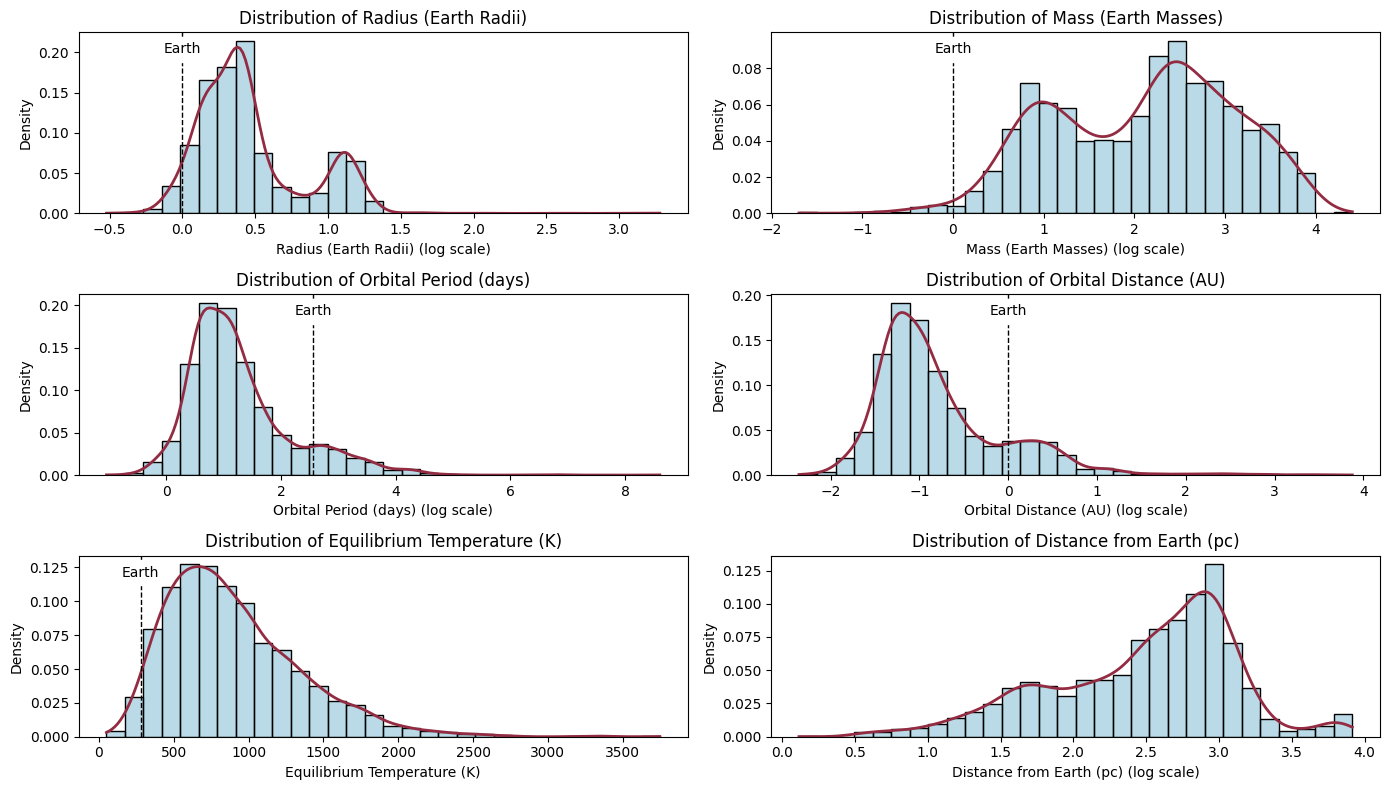

In [64]:
column_mapping = {
    'pl_rade': 'Radius (Earth Radii)',
    'pl_masse': 'Mass (Earth Masses)',
    'pl_orbper': 'Orbital Period (days)',
    'pl_orbsmax': 'Orbital Distance (AU)',
    'pl_eqt': 'Equilibrium Temperature (K)',
    'sy_dist': 'Distance from Earth (pc)',
}
columns_to_plot = list(column_mapping.keys())

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 8))
axes = axes.flatten()

for i, column in enumerate(columns_to_plot):
    data = exoplanets[column] if column == 'pl_eqt' else np.log10(exoplanets[column])
    hist = sns.histplot(x=data, bins=30, stat='probability', kde=True, color='#75b7ce', line_kws={'lw': 2}, ax=axes[i])
    hist.lines[0].set_color('#932c42')
    
    if (column != 'sy_dist'):
        earth_distance = earth[column].iloc[0] if column == 'pl_eqt' else np.log10(earth[column].iloc[0])
        axes[i].axvline(earth_distance, color='black', linestyle='--', label='Earth', linewidth=1)
        axes[i].text(earth_distance, axes[i].get_ylim()[1]*6.5/7.5, 'Earth', color='black', va='bottom', ha='center', backgroundcolor='white', fontsize=10)

    if column == 'pl_eqt':
        axes[i].set_xlabel(f'{column_mapping[column]}')
    else:
        axes[i].set_xlabel(f'{column_mapping[column]} (log scale)')
    axes[i].set_ylabel('Density')
    axes[i].set_title(f'Distribution of {column_mapping[column]}')

plt.tight_layout()
plt.show()

# Orbital Period - Animation

In [151]:
## Define Data for Plots
num_planets = 200# len(solar_exo_animation)
num_frames = 100
num_frames_skipped = np.arange(0, num_frames, 10)
starting_distance = 6

angles = np.zeros((num_frames, num_planets))
x_positions = np.zeros((num_frames, num_planets))
y_positions = np.zeros((num_frames, num_planets))
planet_sizes = np.zeros((num_frames, num_planets))

for i in range(num_frames):
    for j in range(num_planets):
        angle = np.pi * i / (12 * solar_exo_animation['pl_orbper'].iloc[j])
        distance = np.log10(solar_exo_animation['pl_orbsmax'].iloc[j])
        x_position = (distance + starting_distance) * np.sin(angle)
        y_position = (distance + starting_distance) * np.cos(angle)
        
        angles[i][j] = angle
        x_positions[i][j] = x_position
        y_positions[i][j] = y_position
        planet_sizes[i][j] = solar_exo_animation['pl_rade'].iloc[j]


In [153]:
top_10_exoplanets = exoplanets[['pl_name', 'pl_orbper', 'pl_orbsmax']].nlargest(10, 'pl_orbper').reset_index(drop=True)
top_10_exoplanets['pl_orbper'] = top_10_exoplanets['pl_orbper'].astype(int)
top_10_exoplanets['pl_orbsmax'] = top_10_exoplanets['pl_orbsmax'].astype(int)


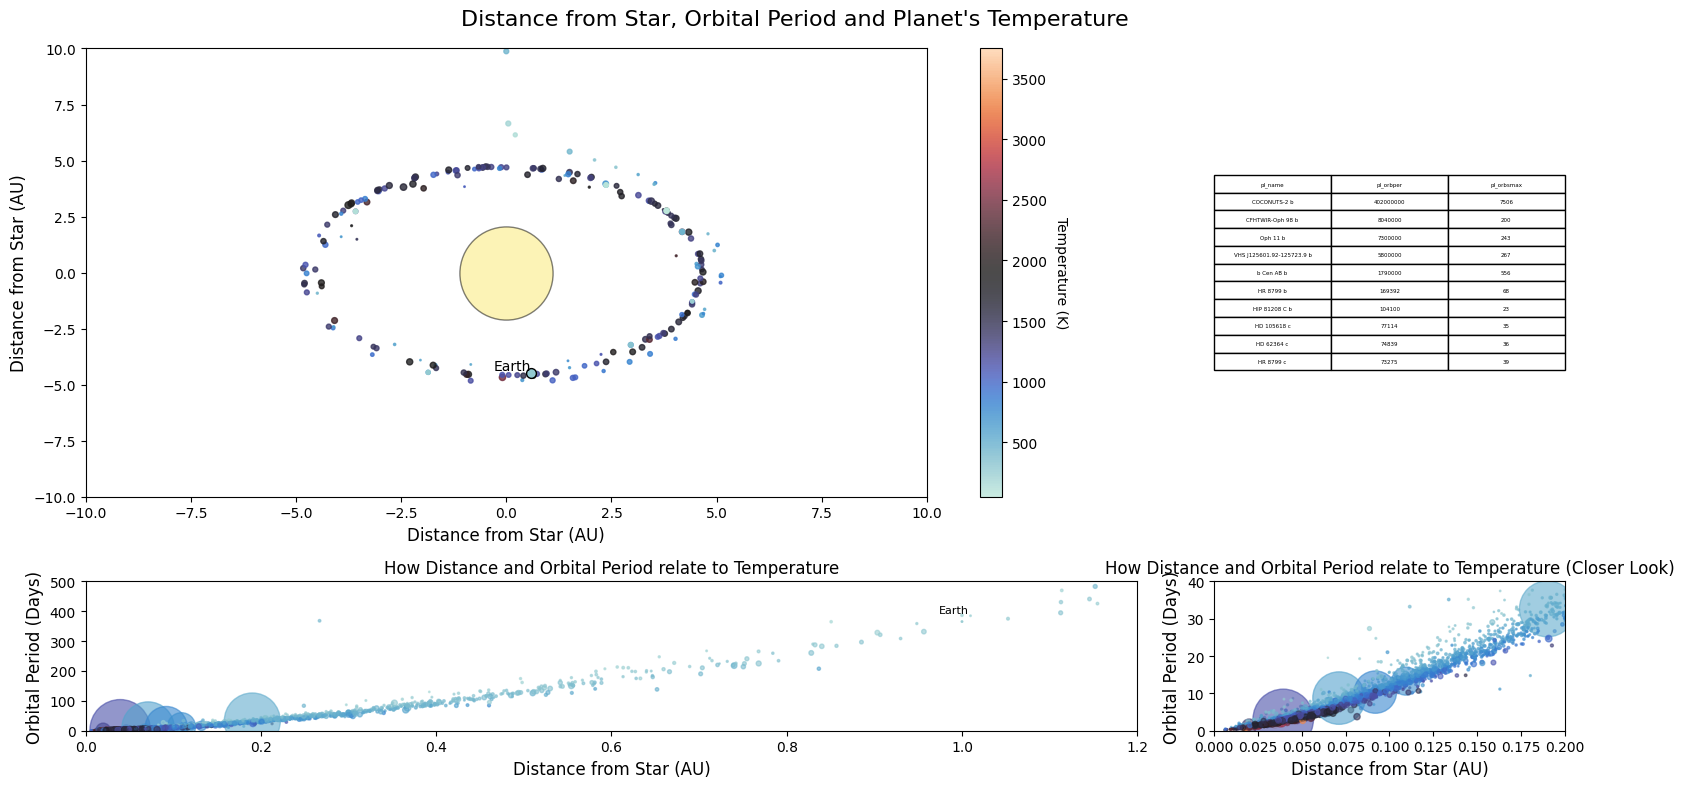

In [154]:
fig = plt.figure(figsize=(16, 8))
gridspan = fig.add_gridspec(2, 2, width_ratios=[3, 1], height_ratios=[3, 1])
fig.suptitle("Distance from Star, Orbital Period and Planet's Temperature", fontsize=16)
 
ax1 = fig.add_subplot(gridspan[0, 0])
ax2 = fig.add_subplot(gridspan[0, 1])
ax3 = fig.add_subplot(gridspan[1, 0])
ax4 = fig.add_subplot(gridspan[1, 1])

ax1.set_xlim(-10, 10)
ax1.set_ylim(-10, 10)
ax1.set_xlabel('Distance from Star (AU)', fontsize=12)
ax1.set_ylabel('Distance from Star (AU)', fontsize=12)

norm = Normalize(vmin=solar_exo_animation['pl_eqt'].min(), vmax=solar_exo_animation['pl_eqt'].max())

k_p = ax1.scatter(x=[], y=[], s=[], c=[], cmap='icefire', alpha=0.8, norm=norm)
s_p = ax1.scatter(x=[], y=[], s=[], c=[], cmap='icefire', norm=norm)
earth = ax1.scatter(x=[], y=[], s=50, c=[], cmap='icefire', edgecolors='black', norm=norm)
earth_text = ax1.text(0, 0, 'Earth', color='black', ha='right', va='bottom')
star = ax1.scatter(x=0, y=0, s=4500, color="#fbe86f", edgecolors='black', alpha=0.5)

cbar_kp = plt.colorbar(k_p, ax=ax1)
cbar_kp.set_label('Temperature (K)', rotation=270, labelpad=15)

def update(i):
    k_p.set_offsets(np.column_stack((x_positions[i % num_frames, :len(solar_exo_animation) - 8],
                                    y_positions[i % num_frames, :len(solar_exo_animation) - 8])))
    k_p.set_sizes(planet_sizes[i % num_frames, :len(solar_exo_animation) - 8])
    k_p.set_array(solar_exo_animation['pl_eqt'].iloc[:len(solar_exo_animation) - 8])
    s_p.set_offsets(np.column_stack((x_positions[i % num_frames, -8:-1],
                                    y_positions[i % num_frames, -8:-1])))
    s_p.set_sizes(planet_sizes[i % num_frames, -8:-1])
    s_p.set_array(solar_exo_animation['pl_eqt'].iloc[-8:-1])
    earth.set_offsets(np.column_stack((x_positions[i % num_frames, -1],
                                    y_positions[i % num_frames, -1])))
    earth.set_array([solar_exo_animation['pl_eqt'].iloc[-1]])
    earth_text.set_position((x_positions[i % num_frames, -1], y_positions[i % num_frames, -1]))

    return k_p, s_p, earth, earth_text

ax2.axis('off')
cell_text = []
for row in top_10_exoplanets.itertuples(index=False):
    cell_text.append(list(row))
table = ax2.table(cellText=cell_text, colLabels=top_10_exoplanets.columns, cellLoc='center', loc='center')


ax3.set_xlim(0, 1.2)
ax3.set_ylim(0, 500)

ax3.scatter(
    x=solar_exo_animation['pl_orbsmax'], 
    y=solar_exo_animation['pl_orbper'], 
    c=solar_exo_animation['pl_eqt'],
    s=solar_exo_animation['pl_rade'], 
    cmap='icefire', 
    alpha=0.6
)

ax3.annotate(
    'Earth', 
     xy=(earth_animation['pl_orbsmax'], earth_animation['pl_orbper']),
     xytext=(5, 5),
     textcoords='offset points',
     ha='right',
     va='bottom',
     fontsize=8,
     color='black'
)

ax3.set_xlabel('Distance from Star (AU)', fontsize=12)
ax3.set_ylabel('Orbital Period (Days)', fontsize=12)
ax3.set_title('How Distance and Orbital Period relate to Temperature', fontsize=12)

ax4.set_xlim(0, 0.2)
ax4.set_ylim(0, 40)

ax4.scatter(
    x=solar_exo_animation['pl_orbsmax'], 
    y=solar_exo_animation['pl_orbper'], 
    c=solar_exo_animation['pl_eqt'],
    s=solar_exo_animation['pl_rade'], 
    cmap='icefire', 
    alpha=0.6
)

ax4.set_xlabel('Distance from Star (AU)', fontsize=12)
ax4.set_ylabel('Orbital Period (Days)', fontsize=12)
ax4.set_title('How Distance and Orbital Period relate to Temperature (Closer Look)', fontsize=12)

plt.tight_layout()

ani = FuncAnimation(fig, update, frames=num_frames, blit=True, interval=200, repeat=False)
ani.save('data/planets_orbiting_star_animation.gif', writer='pillow', fps=30)

# Image(filename='planets_orbiting_star_animation.gif')

![Alt Text](data/planets_orbiting_star_animation.gif)

# Which planets are Inhabitable?

In [65]:
# Habitable Zone Boundaries
def hab_zone_boundaries_lum(stellar_luminosity):
    """
    calculate inner and outer boundaries of the habitable zone based on stellar luminosity

    parameters:
    - stellar_luminosity: stellar luminosity in log(Solar)

    returns:
    - inner_boundary: inner boundary of the habitable zone in AU
    - outer_boundary: outer boundary of the habitable zone in AU
    """

    optimistic_inner_coefficient = 0.75
    optimistic_outer_coefficient = 2
    conservative_inner_coefficint = 0.95
    conservative_outer_coefficient = 1.35

    optimistic_inner_boundary = np.sqrt(10 ** stellar_luminosity) * optimistic_inner_coefficient
    optimistic_outer_boundary = np.sqrt(10 ** stellar_luminosity) * optimistic_outer_coefficient
    conservative_inner_boundary = np.sqrt(10 ** stellar_luminosity) * conservative_inner_coefficint
    conservative_outer_boundary = np.sqrt(10 ** stellar_luminosity) * conservative_outer_coefficient

    return optimistic_inner_boundary, optimistic_outer_boundary, conservative_inner_boundary, conservative_outer_boundary

def hab_remove_outliers(dataframe, window_size, column, cutoff_threshold):
    start = 0
    frames = len(dataframe)//window_size
    indecies = []
    for frame in range(frames):
        window_median = dataframe[column].iloc[start:start+window_size].median()
        for idx, row in dataframe.iloc[start:start+window_size].iterrows():
            if (abs(row[column]-window_median))/window_median > cutoff_threshold:
                indecies.append(idx)
        start += window_size
    for idx, row in dataframe.iloc[start:-1].iterrows():
        window_median = dataframe[column].iloc[start:-1].median()
        if (abs(row[column]-window_median))/window_median > cutoff_threshold:
            indecies.append(idx)

    return indecies

exoplanets[['hab_zone_opt_inner', 'hab_zone_opt_outer', 'hab_zone_con_inner', 'hab_zone_con_outer']] = exoplanets['st_lum'].apply(
    lambda lum: pd.Series(hab_zone_boundaries_lum(lum))
)
exoplanets_hab = exoplanets.copy()
exoplanets_hab = exoplanets_hab.dropna(subset=['hab_zone_opt_inner', 'hab_zone_opt_outer', 'hab_zone_con_inner', 'hab_zone_con_outer', 'st_mass'])
exoplanets_hab = exoplanets_hab.sort_values(by='st_mass')

outliers_indecies = hab_remove_outliers(exoplanets_hab, 200, 'hab_zone_con_inner', 0.2)
exoplanets_hab = exoplanets_hab.drop(outliers_indecies)
exoplanets_hab = exoplanets_hab.sort_values(by='st_mass')

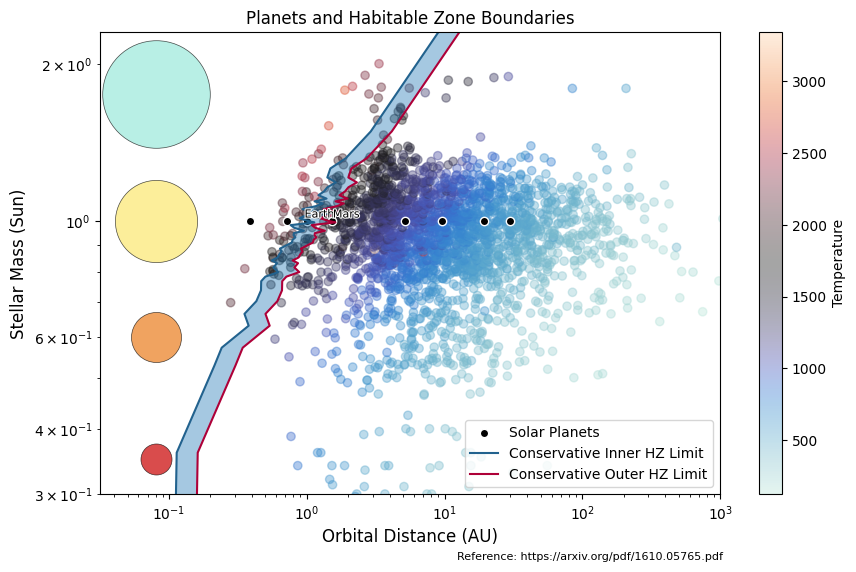

In [150]:
plt.figure(figsize=(10, 6))

scatter_exoplanets = plt.scatter(x=exoplanets_hab['pl_orbper'], y=exoplanets_hab['st_mass'], c=exoplanets_hab['pl_eqt'], alpha=0.4, cmap='icefire')
plt.scatter(x=solarplanets['pl_orbsmax'], y=solarplanets['st_mass'], label='Solar Planets', color='black', edgecolor='white')

# plt.plot(exoplanets_hab['hab_zone_opt_inner'][::60], exoplanets_hab['st_mass'][::60], label='Optimistic Inner HZ Limit', color='red')
plt.plot(exoplanets_hab['hab_zone_con_inner'][::60], exoplanets_hab['st_mass'][::60], label='Conservative Inner HZ Limit', color='#22628e')
plt.plot(exoplanets_hab['hab_zone_con_outer'][::60], exoplanets_hab['st_mass'][::60], label='Conservative Outer HZ Limit', color='#ae0038')
# plt.plot(exoplanets_hab['hab_zone_opt_outer'][::60], exoplanets_hab['st_mass'][::60], label='Optimistic Outer HZ Limit', color='red')
inner_limit = exoplanets_hab['hab_zone_con_inner'][::60]
outer_limit = exoplanets_hab['hab_zone_con_outer'][::60]
st_mass = exoplanets_hab['st_mass'][::60]
plt.fill_betweenx(st_mass, inner_limit, outer_limit, cmap='RdYlGn', alpha=0.4)

planet_names = ['Earth', 'Mars']
for planet_name in planet_names:
    plt.annotate(
        planet_name, 
        xy=(solarplanets[solarplanets['pl_name']==planet_name]['pl_orbsmax'], solarplanets[solarplanets['pl_name']==planet_name]['st_mass']),
        xytext=(20, 1),
        textcoords='offset points',
        ha='right',
        va='bottom',
        fontsize=8,
        color='black',
        path_effects=[pe.withStroke(linewidth=1.5, foreground="white")]
    )

plt.xscale('log')
plt.yscale('log')
plt.xlim(10**(-1.5), 10**3)
plt.ylim(0.3, 10**0+1.3)

star_x = 0.08
star_y = [0.35, 0.6, 1, 1.75]
star_sizes = [500, 1300, 3500, 6000]
star_colors = ['#c90000', '#eb7c1c', '#fbe86f', '#9be9da']
for idx, _ in enumerate(star_y):
    plt.scatter(x=star_x, y=star_y[idx], s=star_sizes[idx], marker='o', color=star_colors[idx], edgecolors='black', linewidth=0.5, alpha=0.7)

cbar = plt.colorbar(scatter_exoplanets, label='Temperature', orientation='vertical')
plt.title('Planets and Habitable Zone Boundaries', fontsize=12)
plt.xlabel('Orbital Distance (AU)', fontsize=12)
plt.ylabel('Stellar Mass (Sun)', fontsize=12)
plt.legend(loc='lower right')
reference_text = 'Reference: https://arxiv.org/pdf/1610.05765.pdf'
plt.figtext(0.615, 0, reference_text, wrap=True, horizontalalignment='center', fontsize=8)
plt.show()

- Inner Boundary: 0.95 AU from the star. This is the distance from the star where the greenhouse effect becomes too strong making the surface temperature too hot for liquid water.
- Outer Boundary: 1.37 AU from the Star. Beyond this distance, the greenhouse effect is not sufficient to keep the surface temperature warm enough for liquid water to exist.